These data are from the IEEE-CIS Fraud Detection kaggle competition in which the goal is to predict fraudulent credit card transactions. The data include several hundred features including encompassing discrete and continuous variables such as product code for each transaction, days between previous transactions, and maching between cards and addresses.

In [1]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pydot
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

First, we'll load the dataframe and take a look its structure and class proprotions. It turns out that there are far more non-fraudulent than fraudulent transactions, indicating a strong class imbalance. The end result of this is that predicting each row to be non-fraudulent will result in 95% accuracy.

In [14]:
os.chdir('C:/Users/JDawg/Documents/python/fraud detection/data')

train = pd.read_csv('rf_with_ys.csv')

frauds = train['isFraud'].value_counts()

print('Number of observations in dataframe:', '%d' % train.shape[0])
print('Number of features:', '%d' % train.shape[1])
print('Number of non-fraudulent transactions in full data:', '%d' % (frauds[0]))
print('Number of fraudulent transactions:', '%d' % (frauds[1]))
print('Proportion of fraudulent transactions:', '{:.2f}'.format(frauds[1]/len(train)))

Number of observations in dataframe: 10000
Number of features: 420
Number of non-fraudulent transactions in full data: 9521
Number of fraudulent transactions: 479
Proportion of fraudulent transactions: 0.05


Next, we'll construct a standardizing function. This function first replaces all NaNs with the column mean and then standardizes each value by subtracting the column mean and dividing by the standard deviation. Since the class labels are included in this dataframe, we'll also want to remove this column so we can just feed the whole dataframe directly into the training model.

In [3]:
def standardize(train):
    y = train.pop('isFraud').values
    x = train.values
    
    # Set nans to mean
    isnan = np.isnan(x)
    means = np.repeat([np.nanmean(x, 0)], x.shape[0], 0)
    x = np.where(isnan, means, x)
    
    # Standardize the columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    return x, y

x, y = standardize(train)

Here is a simple function which splits the data into a training and test set based on a chosen ratio.

In [4]:
def split_training_data(x, y, ratio):
        test_idx = int(x.shape[0] * ratio)
        x_train = x[:test_idx]
        y_train = y[:test_idx]
        x_test = x[test_idx:]
        y_test = y[test_idx:]
        
        return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_training_data(x, y, 0.8)

Let's outline the structure of the model. It will have three layers, including one hidden layer with 500 nodes (this was identified as optimal through cross validation), with a tanh/tanh/sigmoid activation function setup. We will evaluate the model on the basis of the count of correctly classified positives and negatives, as well as its precision and recall.

In [9]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(train.shape[1], activation='tanh'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(500, activation='tanh'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        tf.keras.layers.Dropout(0.3)
        ])
    
model.compile(optimizer='adam', loss='mean_absolute_error',
              metrics=[tf.keras.metrics.TrueNegatives(name='True_Negatives'),
              tf.keras.metrics.FalseNegatives(name='False_Negatives'),
              tf.keras.metrics.TruePositives(name='True_Positives'),
              tf.keras.metrics.FalsePositives(name='False_Positives'),
              tf.keras.metrics.Precision(name='Precision'),
              tf.keras.metrics.Recall(name='Recall')])
                       

SMOTE (synthetic minority oversampling technique) is a method for resampling unbalanced datasets. Using the function fit_sample will produce a dataframe with an equal representation of both classes (roughly twice the size of the original). These additional fraud values are predicted based on a random distance between feature values and their nearest neighbors on fraud cases.

In [37]:
smote = SMOTE()
x_resampled, y_resampled = smote.fit_sample(x_train, y_train)

In [39]:
epochs=100
history = model.fit(x_resampled, y_resampled, epochs=epochs, verbose=False)

In [40]:
results = model.evaluate(x_test, y_test)
for name, value in zip(model.metrics_names, results):
  print(str(name) + ': ' + str(value))

2000/2000 [==============================] - 0s 129us/sample - loss: 0.0999 - True_Negatives: 1747.0000 - False_Negatives: 29.0000 - True_Positives: 48.0000 - False_Positives: 176.0000 - Precision: 0.2143 - Recall: 0.6234
loss: 0.09993492643535137
True_Negatives: 1747.0
False_Negatives: 29.0
True_Positives: 48.0
False_Positives: 176.0
Precision: 0.21428572
Recall: 0.6233766


Let's visualize the loss function over each epoch:

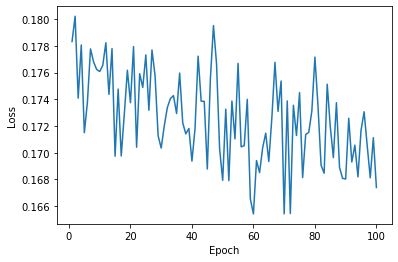

In [49]:
epochs_list = range(1, epochs+1)
plt.plot(epochs_list, history.history['loss'])
plt.xlabel('Epoch')
ylab = plt.ylabel('Loss')

The loss displays a general downward trend, which is what we're after. Now let's take a look at the precision network, which is the percentage of predicted fraud cases that were correctly classified:

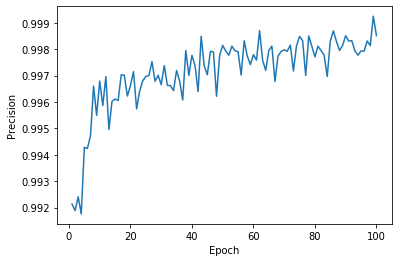

In [50]:
plt.plot(epochs_list, history.history['Precision'])
plt.xlabel('Epoch')
ylab = plt.ylabel('Precision')

Our precision is showing a consistent upward trend, which again is what we're after.

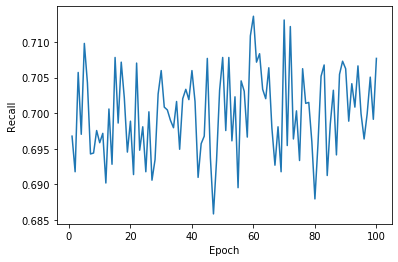

In [51]:
plt.plot(epochs_list, history.history['Recall'])
plt.xlabel('Epoch')
ylab = plt.ylabel('Recall')

Recall is the percantage of actual fraud cases that are correctly classified. 

We can contrast our neural network approach with random forest classification, which is somewhat simpler to implement. Since our data has already been cleaned, at this point all we have to do is build a classifier using tuning parameters. For the classification model in sklearn, the tuning parameter n_estimators refers to the numebr of trees in the "forest" which will vote on the class label fo a given row.

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
precision = round(tp / (tp + fp), 2)
recall = tp / (tp + fn)
print('Precision:', '%d' % (precision))
print(recall)

NameError: name 'predictions' is not defined

In [14]:
features = list(train.columns)

tree = rf.estimators_[500]
export_graphviz(tree, out_file = 'rf.dot', feature_names = features,
                rounded = True)
(graph, ) = pydot.graph_from_dot_file('rf.dot')

graph.write_png('tree.png')